# Particle physics results

## Setup

In [14]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import corner
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import roc_auc_score

sys.path.append("../../")
from experiments.simulators.collider import WBFLoader


## Helper functions

In [15]:
def histo_w_err(
    xvals, xmin, xmax, nbins,
    ls="-", m=" ", ms=6., c="black",
    label=None, alpha=0.1,
    subtract_min=False, plot_individual=False,
    **kwargs
):
    # Calculate histograms
    histos = []
    for x in xvals:
        histo, bin_edges = np.histogram(x, bins=nbins, range=(xmin, xmax), density=True)
        histos.append(histo)
    histos = np.array(histos)

    # Mean and error band
    y_mean, y_err = np.nanmean(histos, axis=0), np.nanstd(histos, axis=0)
    
    x_ = np.repeat(bin_edges, 2)[1:-1]
    y_ = np.repeat(y_mean, 2)
    y_err_ = np.repeat(y_err, 2)
    yis_ = [np.repeat(y, 2) for y in histos]
    
    # Plot
    plt.fill_between(x_, y_ - y_err_, y_ + y_err_, color=c, alpha=alpha)
    plt.plot(x_, y_, label=label, ls=ls, marker=m, ms=ms, c=c, lw=1.5, **kwargs)
    
    if plot_individual:
        for yi_ in yis_:
            plt.plot(x_, yi_, ls=ls, lw=0.5, c=c)
    

## Load results

In [16]:
n_runs = 3

In [17]:
algo_filenames = []
algo_additionals = []
algo_labels = []
algo_colors = []
algo_markers = []
algo_linestyles = []

def add_algo(filename, add, label, c, m, ls):
    algo_filenames.append(filename)
    algo_additionals.append(add)
    algo_labels.append(label)
    algo_colors.append(c)
    algo_markers.append(m)
    algo_linestyles.append(ls)
    
add_algo("flow", "_march", "EF", "C0", "s", "-")
add_algo("pie", "_march", "PIE", "C4", "s", "--") 
add_algo("mf", "_alternate_march", "MLF-A", "C3", "s", "-")
add_algo("gamf", "_march", "MLF-OT", "C1", "s", "--") 
add_algo("gamf", "_alternate_march", "MLF-OTA", "C1", "s", "-") 
add_algo("emf", "_alternate_march", "EMLF-A", "C2", "s", "-")


In [18]:
def load(name, shape, numpyfy=True, result_dir="../data/results"):
    all_results = []
    
    for algo_filename, algo_add in zip(algo_filenames, algo_additionals):
        algo_results = []
            
        for run in range(n_runs):
            run_str = "" if run == 0 else "_run{}".format(run)
            try:
                this_result = np.load(
                    "{}/{}_14_lhc{}{}_{}.npy".format(
                        result_dir, algo_filename, algo_add, run_str, name
                    )
                )
                if (not numpyfy) or (shape is None) or np.product(this_result.shape) == np.product(shape):
                    algo_results.append(this_result.reshape(shape))
                else:
                    algo_results.append(np.nan*np.ones(shape))
                    
            except FileNotFoundError as e:
                if shape is None:
                    algo_results.append(None)
                else:
                    algo_results.append(np.nan*np.ones(shape))
            
        all_results.append(algo_results)
    
    if numpyfy:
        all_results = np.array(all_results, dtype=np.float)
        
    return all_results


model_gen_x = load("samples", None, numpyfy=False)
model_gen_closure = load("samples_manifold_distance", (10000,))
model_test_logp = load("model_log_likelihood_test", (11*11, 1000,))
model_test_reco_error = load("model_reco_error_test", (1000,))
model_posterior_samples = load("posterior_samples", (5000, 2,))


In [19]:
sim = WBFLoader()

test_x, _ = sim.load_dataset(train=False, dataset_dir="../data/samples/lhc", numpy=True)

test_closure = sim.distance_from_manifold(test_x)

In [7]:
def remove_nans(*results):
    passes = all([np.all(np.isfinite(result)) for result in results])
    
    if passes:
        return results
    else:
        return [np.nan * np.ones_like(result) for result in results]


def remove_nans_from_lists(*raws):
    # raws[quantity][algo]
    n_quantities = len(raws)
    n_algos = len(raws[0])
    
    for raw in raws:
        assert len(raw) == n_algos
    
    cleans = [[[] for _ in range(n_algos)] for _ in range(n_quantities)]
    
    for i in range(n_algos):
        for k in range(n_runs):
            clean = remove_nans(*[raw[i][k] for raw in raws])
            for j in range(n_quantities):
                cleans[j][i].append(clean[j])
            
    cleans = [np.array(clean) for clean in cleans]
    
    # cleans[quantity][algo]
    return cleans
            
raw = [model_gen_closure, model_posterior_samples]
clean = remove_nans_from_lists(*raw)
model_gen_closure, model_posterior_samples = clean


## Calculate metrics

In [20]:
n_observed = 100
min_logp = -100.
max_closure = 1.e9

test_mean_closure = np.mean(np.clip(test_closure, None, max_closure), axis=-1)

model_gen_mean_closure = np.mean(np.clip(model_gen_closure, None, max_closure), axis=2)
model_expected_nll = -2. * np.mean(model_test_logp[:,:,:,:], axis=-1)
model_observed_nll = -2. * np.sum(model_test_logp[:,:,:,:n_observed], axis=-1)


## Generative mode: closure test

/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


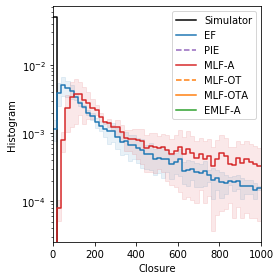

In [21]:
xmin, xmax = 0.,1.e3
bins = 50

fig = plt.figure(figsize=(4, 4))
ax = plt.gca()
    
histo_w_err(
    test_closure,
    xmin, xmax, bins,
    label="Simulator",
    c="black",
)

for closure, algo_label, c, m, ls in zip(model_gen_closure, algo_labels, algo_colors, algo_markers, algo_linestyles):
    histo_w_err(
        closure,
        xmin, xmax, bins,
        label=algo_label,
        c=c,
        ls=ls,
    )

plt.legend()

plt.xlabel(r"Closure")
plt.ylabel(r"Histogram")
plt.xlim(xmin, xmax)
plt.yscale("log")
#plt.ylim(1.e-1, 1.e3)
    
plt.tight_layout()
plt.savefig("../figures/lhc_generated_samples_closure.pdf")


## Likelihood maps

/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


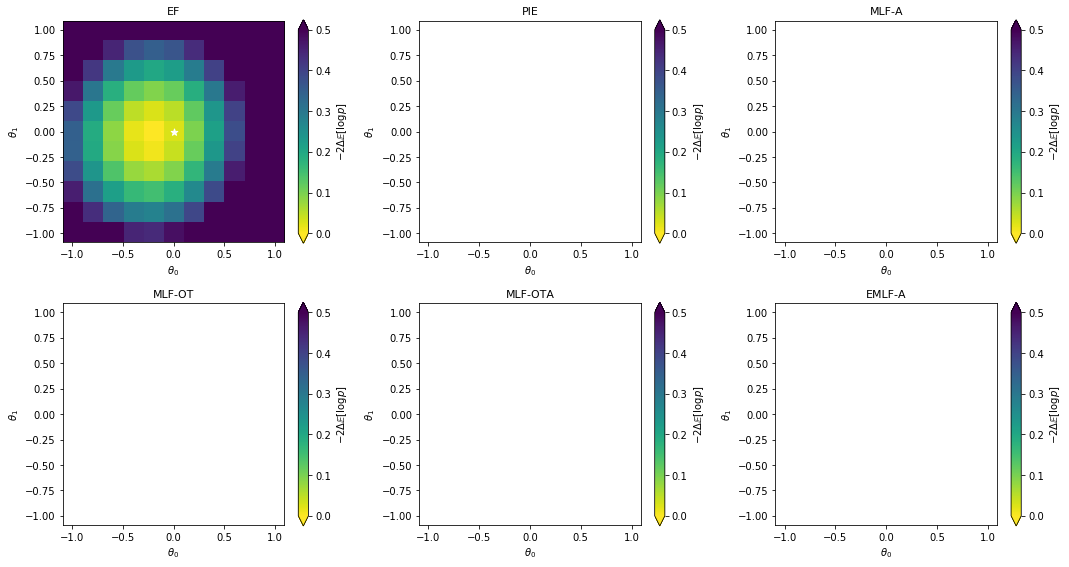

In [10]:
cmin, cmax = 0.,0.5
extent = (-1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11, -1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11)

ncols = 3
nrows = (len(algo_labels) - 1) // ncols + 1

fig = plt.figure(figsize=(ncols*5., nrows*4))

for i, (label, nll) in enumerate(zip(algo_labels, model_expected_nll)):
    ax = plt.subplot(nrows, ncols, i + 1)
    
    logp = np.nanmean(nll, axis=0)
    logp = logp.reshape((11,11)) - np.min(logp)
    logp = np.clip(logp, cmin, cmax)
                                 
    im = plt.imshow(logp.T, extent=extent, vmin=cmin, vmax=cmax, origin="lower", cmap="viridis_r")
    cb = plt.colorbar(im, extend="both")
    plt.scatter([0.], [0.], marker="*", s=50, color="white")

    plt.title(label, fontsize=11)
    plt.xlabel(r"$\theta_0$")
    plt.ylabel(r"$\theta_1$")
    cb.set_label(r"$-2 \Delta \mathbb{E}[\log p]$")

plt.tight_layout()
plt.savefig("../figures/lhc_test_expected_likelihood_maps.pdf")


/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


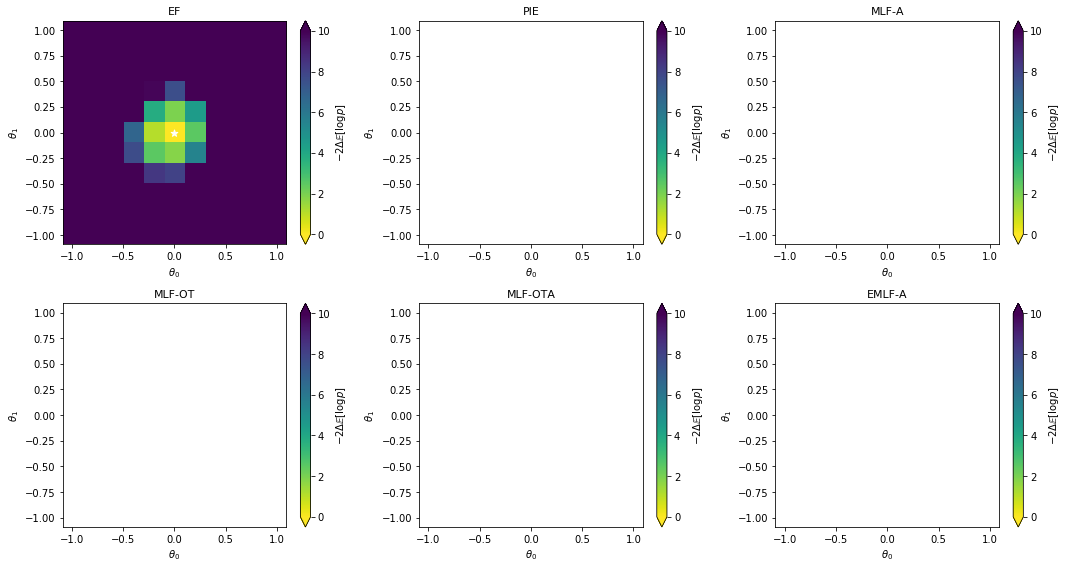

In [11]:
cmin, cmax = 0.,10.
extent = (-1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11, -1. - 0.5 * 2. / 11, 1. + 0.5 * 2. / 11)

ncols = 3
nrows = (len(algo_labels) - 1) // ncols + 1

fig = plt.figure(figsize=(ncols*5., nrows*4))

for i, (label, nll) in enumerate(zip(algo_labels, model_observed_nll)):
    ax = plt.subplot(nrows, ncols, i + 1)
    
    logp = np.nanmean(nll, axis=0)
    logp = logp.reshape((11,11)) - np.min(logp)
    logp = np.clip(logp, cmin, cmax)
                                 
    im = plt.imshow(logp.T, extent=extent, vmin=cmin, vmax=cmax, origin="lower", cmap="viridis_r")
    cb = plt.colorbar(im, extend="both")
    plt.scatter([0.], [0.], marker="*", s=50, color="white")

    plt.title(label, fontsize=11)
    plt.xlabel(r"$\theta_0$")
    plt.ylabel(r"$\theta_1$")
    cb.set_label(r"$-2 \Delta \mathbb{E}[\log p]$")

plt.tight_layout()
plt.savefig("../figures/lhc_test_observed_likelihood_maps.pdf")


## Posterior plots

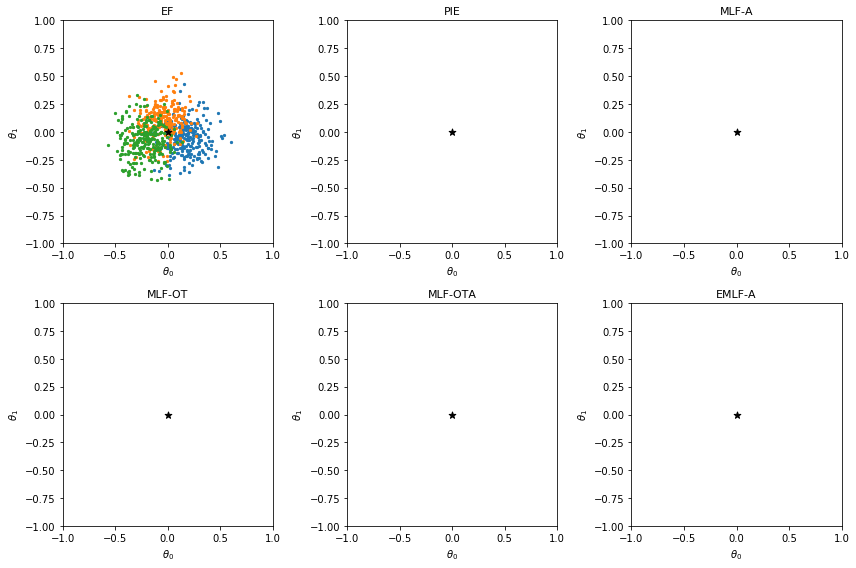

In [12]:
skip = 20

ncols = 3
nrows = (len(algo_labels) - 1) // ncols + 1

fig = plt.figure(figsize=(ncols*4., nrows*4.))

for i, (label, posteriors) in enumerate(zip(algo_labels, model_posterior_samples)):
    ax = plt.subplot(nrows, ncols, i + 1)
    
    for posterior, c in zip(posteriors, ["C0", "C1", "C2"]):
        plt.scatter(posterior[::skip, 0], posterior[::skip, 1], c=c, s=5.)
    plt.scatter([0.], [0.], marker="*", s=50, color="black")
    
    plt.xlim(-1.,1.)
    plt.ylim(-1.,1.)

    plt.title(label, fontsize=11)
    plt.xlabel(r"$\theta_0$")
    plt.ylabel(r"$\theta_1$")

plt.tight_layout()
plt.savefig("../figures/lhc_posterior_scatter.pdf")


/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


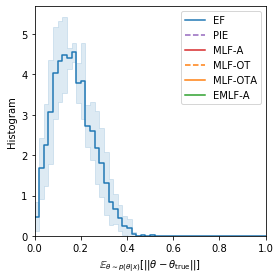

In [13]:
dmin, dmax = 0., 1.

fig = plt.figure(figsize=(4.,4.))

for i, (label, samples, c, ls) in enumerate(zip(algo_labels, model_posterior_samples, algo_colors, algo_linestyles)):
    posterior_diffs = np.mean(samples**2, axis=-1)**0.5
    
    histo_w_err(posterior_diffs, dmin, dmax, 50, c=c, ls=ls, alpha=0.15, label=label)
    plt.legend()
    
    plt.xlim(dmin, dmax)
    plt.ylim(0., None)

    plt.xlabel(r"$\mathbb{E}_{\theta \sim p(\theta | x)} [ || \theta - \theta_\mathrm{true} || ]$")
    plt.ylabel("Histogram")

plt.tight_layout()
plt.savefig("../figures/lhc_posterior_distance.pdf")
